# Visualize current data

Originally https://colab.research.google.com/drive/1O7ltZ7KHdeaatc6PTBIbkmJrsv81e6KO#scrollTo=qSrHkhOMcDef

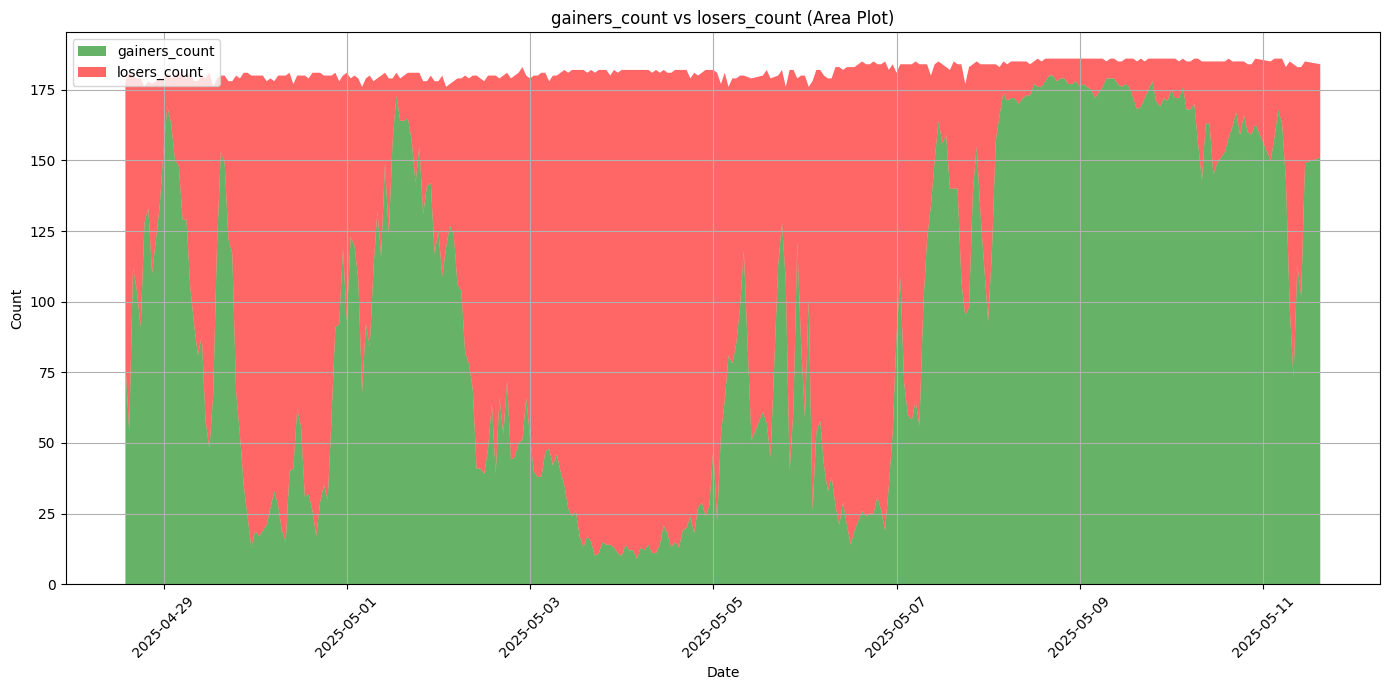

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import requests

# Step 2: Fetch data
url = "https://api.terminal.binbot.in/charts/market-domination?size=300"
response = requests.get(url)
data = response.json()

df = pd.DataFrame(data['data'])
df['dates'] = pd.to_datetime(df['dates'])
df = df.dropna()
df = df[(df != 0).all(axis=1)]

plt.figure(figsize=(14, 7))
plt.stackplot(df['dates'], df['gainers_count'], df['losers_count'],
              labels=['gainers_count', 'losers_count'],
              colors=['green', 'red'], alpha=0.6)
plt.title('gainers_count vs losers_count (Area Plot)')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend(loc='upper left')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Identify reversals

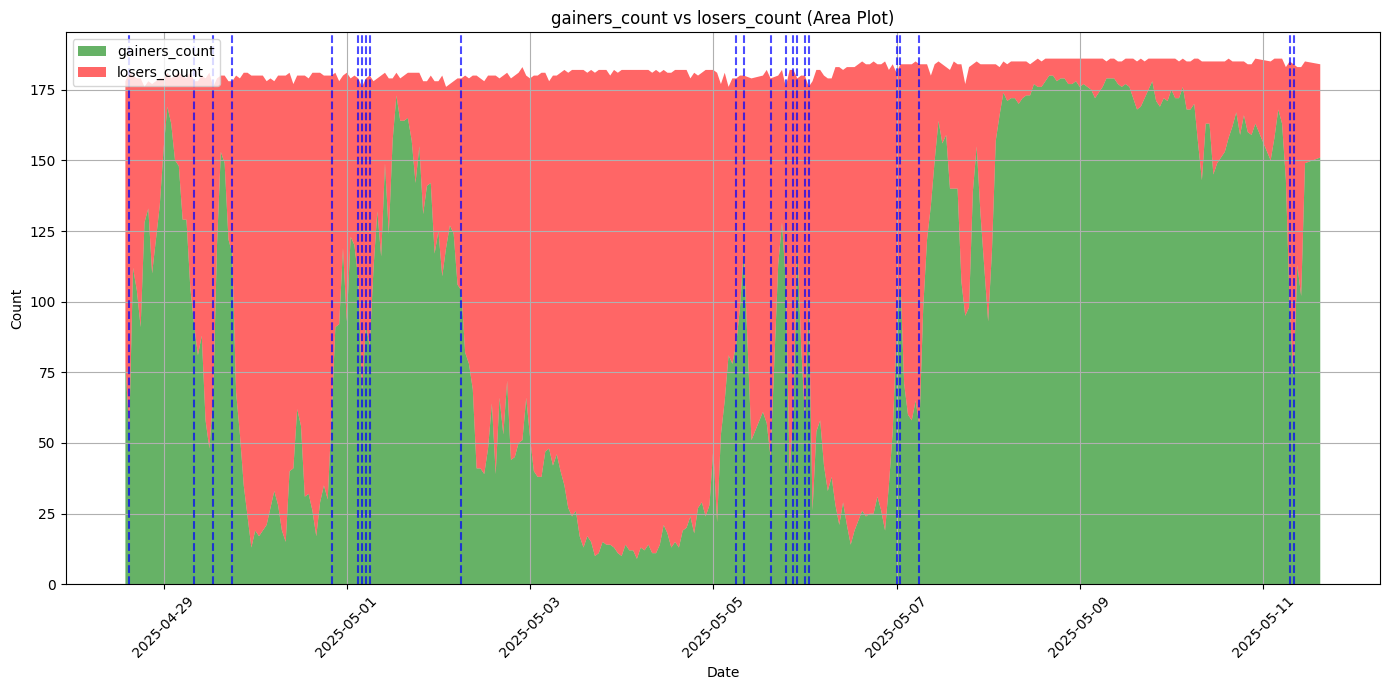

In [2]:
# Calculate the difference between gainers and losers
df['diff'] = df['gainers_count'] - df['losers_count']

# Identify sign changes and get corresponding timestamps
reversals = df[df['diff'].shift(1) * df['diff'] < 0]['dates']

# Display the reversal timestamps
plt.figure(figsize=(14, 7))
plt.stackplot(df['dates'], df['gainers_count'], df['losers_count'],
              labels=['gainers_count', 'losers_count'],
              colors=['green', 'red'], alpha=0.6)
plt.title('gainers_count vs losers_count (Area Plot)')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend(loc='upper left')
plt.grid(True)
plt.xticks(rotation=45)

# Plot vertical lines at reversal points
for reversal_date in reversals:
    plt.axvline(x=reversal_date, color='blue', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# Prediction with TSMixer

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | fc_hist             | Linear           | 4.1 K  | train
6 | feature_mixing_hist | _FeatureMixing   | 7.7 K  | train
7 | conditional_mixer   | ModuleList       | 30.1 K | train
8 | fc_out              | Linear           | 65     | train
-----------------------------------------------------------------
42.0 K    Trainable params
0         Non-trainable params
42.0 K    Total p

Epoch 199: 100%|██████████| 8/8 [00:00<00:00, 54.79it/s, train_loss=0.00143] 

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 199: 100%|██████████| 8/8 [00:00<00:00, 54.55it/s, train_loss=0.00143]



GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 161.37it/s]



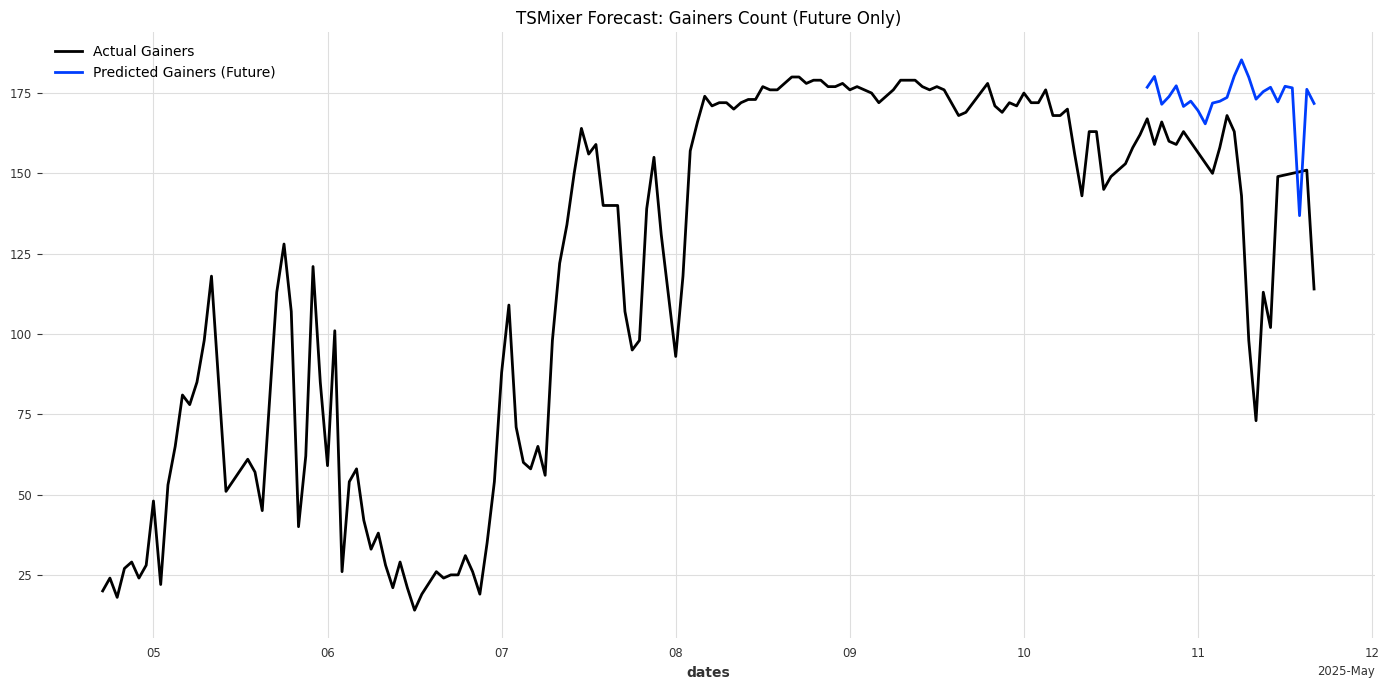

In [ ]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
from darts import TimeSeries
from darts.models import TSMixerModel
from darts.dataprocessing.transformers import Scaler, MissingValuesFiller

# Step 2: Fetch data
url = "https://api.terminal.binbot.in/charts/market-domination?size=2000"
response = requests.get(url)
data = response.json()

df = pd.DataFrame(data['data'])

# Convert 'dates' column to datetime objects
df['dates'] = pd.to_datetime(df['dates'], format='%Y-%m-%d %H:%M:%S.%f')

df = df.dropna()
df = df[(df != 0).all(axis=1)]
df = df.iloc[1:]
# Interpolate missing values in the DataFrame before creating TimeSeries
if df.isnull().values.any():
    df = df.interpolate()


# Set 'dates' as the index
if 'dates' in df.columns:
    df.set_index('dates', inplace=True)
df.sort_index(inplace=True)

# Feature Engineering: Create a 'reversal' column
df['diff'] = (df['gainers_count'] - df['losers_count']).astype("float32")
df['reversal'] = (df['diff'].shift(1) * df['diff'] < 0).astype("float32")
df['gainers_count'] = df['gainers_count'].astype("float32")
df['losers_count'] = df['losers_count'].astype("float32")
df["total_volume"] = df["total_volume"].astype("float32")

# Target series: only gainers_count
series = TimeSeries.from_dataframe(
    df,
    value_cols=['gainers_count'],
    fill_missing_dates=True,
    freq="h"
)

# Exogenous variables: losers_count and total_volume as past covariates
covariates = TimeSeries.from_dataframe(
    df,
    value_cols=['losers_count', 'total_volume'],
    fill_missing_dates=True,
    freq="h"
)

# Normalize
scaler = Scaler()
filler = MissingValuesFiller()
# Resample and interpolate missing values to handle data gaps
series = filler.transform(series, method="linear")
series_scaled = scaler.fit_transform(series)
# Resample and interpolate missing values to handle data gaps
covariates = filler.transform(covariates, method="linear")
covariate_scaler = Scaler()
covariates_scaled = covariate_scaler.fit_transform(covariates)

# Train/Val Split
input_chunk_length = 168
forecast_horizon = 24

train, val = series_scaled[:-forecast_horizon], series_scaled[-forecast_horizon:]
# Adjust covariates to match the input_chunk_length requirement
cov_train, cov_val = covariates_scaled[-(len(train) + input_chunk_length):-forecast_horizon], covariates_scaled[-(forecast_horizon + input_chunk_length):]

# Initialize and train TSMixer
model = TSMixerModel(
    input_chunk_length=168,
    output_chunk_length=24,
    n_epochs=200,
    batch_size=16,
    random_state=42,
    optimizer_kwargs={"lr": 1e-3}
)

model.fit(train, past_covariates=cov_train, verbose=True)

# Forecast
forecast = model.predict(n=forecast_horizon, past_covariates=cov_val)

# Invert scaling to get predictions in original scale
forecast_orig = scaler.inverse_transform(forecast)

# Plot predictions with actual losers_count
plt.figure(figsize=(14, 7))
series[-168:].plot(label="Actual Gainers")
forecast_orig.plot(label="Predicted Gainers")
# Align losers_count index with series for correct dates
losers_aligned = pd.Series(df['losers_count'][-168:].values, index=series[-168:].time_index)
losers_aligned.plot(label="Actual Losers")
plt.title("TSMixer Forecast: Gainers Count (with Actual Losers)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()